### Importando as bibliotecas

In [100]:
import pandas as pd
import numpy as np

#NLTK
import nltk
import re
import string
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#ML Libs
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn import preprocessing

#Metrics libs
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

#Data Vis
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
# import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

### Análise Exploratória dos Dados e Pré-processamento

In [56]:


reviews = pd.read_csv('data/Musical_instruments_reviews.csv')
print(f"Shape: {reviews.shape}")
reviews.head()

Shape: (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


#### Obtendo valores nulos
- A coluna reviewerName foi retirada pois não é relevante para a análise e possui muitos valores nulos
- As linhas nulas de reviewText foram retiradas pois é o alvo da análise textual de sentimentos

In [57]:
#Checando Valores Nulos
print(reviews.isnull().sum())
#Drop da coluna reviewerName
reviews.drop('reviewerName', axis=1, inplace=True)
#Drop das linhas com reviewText nulo
reviews.dropna(subset=['reviewText'], inplace=True)
print("--------------------")
print(reviews.isnull().sum())
print("--------------------")
#Drop da linha unixReviewTime que não agrega informações na análise
reviews.drop('unixReviewTime', axis=1, inplace=True)
print("--------------------")
print(f"New shape: {reviews.shape}")


reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64
--------------------
reviewerID        0
asin              0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64
--------------------
--------------------
New shape: (10254, 7)


In [58]:
## Concatenando as colunas Texto da Review (reviewText) e Resumo (summary)
# reviews['reviews']=reviews['reviewText']+reviews['summary']
# reviews=reviews.drop(['reviewText', 'summary'], axis=1)
# reviews.head()

#### Entendendo a distribuição dos dados na coluna overall
- Com os valores inteiros entre 1 e 5 obtidos, é possível criar uma nova coluna com a classificação de sentimentos sendo esta positiva, para valores de overall maiores que 3, neutra para valores de overall iguais a 3 e negativa para valores de overall menores que 3.
- Com o histograma dessas classificações já é possível observar que a maioria das avaliações são positivas e representam cerca de 88% de todos os dados

[5. 3. 4. 2. 1.]
overall
5.0    0.676029
4.0    0.203140
3.0    0.075288
2.0    0.024381
1.0    0.021162
Name: proportion, dtype: float64


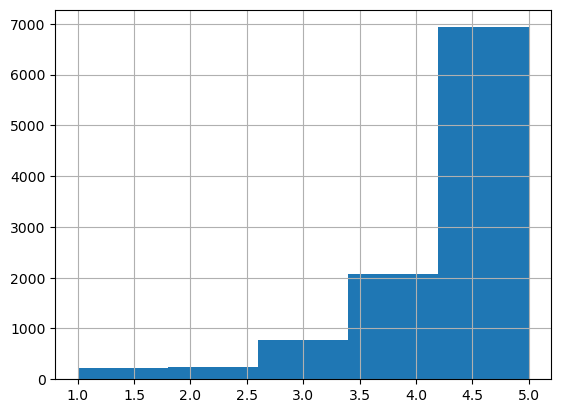

In [59]:
# Obtendo valores únicos da coluna overall
print(reviews['overall'].unique())

#Histograma da coluna overall
reviews['overall'].hist(bins=5)

#Porcentagem de cada nota
print(reviews['overall'].value_counts(normalize=True))

In [60]:
# Função para classificar as notas em positivas, neutras e negativas

sentiment = lambda x: 'positivo' if x >= 4 else 'negativo' if x <= 2 else 'neutro'
reviews['sentiment'] = reviews['overall'].apply(sentiment)
reviews.head()

,reviewerID,asin,helpful,reviewText,overall,summary,reviewTime,sentiment
0,A2IBPI20UZIR0U,1384719342,"[0, 0]","Not much to write about here, but it does exac...",5.0,good,"02 28, 2014",positivo
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,"03 16, 2013",positivo
2,A195EZSQDW3E21,1384719342,"[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,"08 28, 2013",positivo
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,"02 14, 2014",positivo
4,A94QU4C90B1AX,1384719342,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,"02 21, 2014",positivo


In [61]:
# Transformando a coluna reviewTime em datetime
reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'], format='%m %d, %Y')
reviews.head()

,reviewerID,asin,helpful,reviewText,overall,summary,reviewTime,sentiment
0,A2IBPI20UZIR0U,1384719342,"[0, 0]","Not much to write about here, but it does exac...",5.0,good,2014-02-28,positivo
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,2013-03-16,positivo
2,A195EZSQDW3E21,1384719342,"[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,2013-08-28,positivo
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,2014-02-14,positivo
4,A94QU4C90B1AX,1384719342,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,2014-02-21,positivo


,reviewerID,asin,reviewText,overall,summary,reviewTime,sentiment,helpful_rate
0,A2IBPI20UZIR0U,1384719342,"Not much to write about here, but it does exac...",5.0,good,2014-02-28,positivo,0.00
1,A14VAT5EAX3D9S,1384719342,The product does exactly as it should and is q...,5.0,Jake,2013-03-16,positivo,0.93
2,A195EZSQDW3E21,1384719342,The primary job of this device is to block the...,5.0,It Does The Job Well,2013-08-28,positivo,1.00
3,A2C00NNG1ZQQG2,1384719342,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,2014-02-14,positivo,0.00
4,A94QU4C90B1AX,1384719342,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,2014-02-21,positivo,0.00


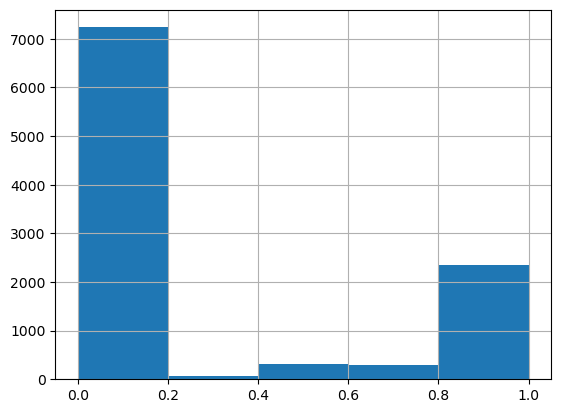

In [62]:
# Obtendo taxa de avaliações úteis
def get_helpful_rate(x):
    try:
      lista = eval(x)
      rate = (lista[0]/lista[1])
      return round(rate, 2)
    except:
      return 0

reviews['helpful_rate'] = reviews['helpful'].apply(get_helpful_rate)
#Histograma da coluna helpful_rate
reviews['helpful_rate'].hist(bins=5)
reviews.drop('helpful', axis=1, inplace=True)
reviews.head()

Observando a distribuição dos dados na nova coluna helpful_rate, é possível observar que grande parte não são úteis ou não foram classificados. Contudo, uma parte considerável, cerca de 30%, possuem tal classificação.

#### Agregando as colunas reviewText e summary

In [63]:
reviews['reviews'] = reviews['summary'] + ' ' + reviews['reviewText']
reviews.drop(['reviewText', 'summary'], axis=1, inplace=True)
reviews.head()

,reviewerID,asin,overall,reviewTime,sentiment,helpful_rate,reviews
0,A2IBPI20UZIR0U,1384719342,5.0,2014-02-28,positivo,0.00,"good Not much to write about here, but it does..."
1,A14VAT5EAX3D9S,1384719342,5.0,2013-03-16,positivo,0.93,Jake The product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,5.0,2013-08-28,positivo,1.00,It Does The Job Well The primary job of this d...
3,A2C00NNG1ZQQG2,1384719342,5.0,2014-02-14,positivo,0.00,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,A94QU4C90B1AX,1384719342,5.0,2014-02-21,positivo,0.00,No more pops when I record my vocals. This pop...


#### Removendo pontuações e transformando em minúsculas

In [64]:

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [65]:
reviews['reviews']=reviews['reviews'].apply(lambda x:review_cleaning(x))
reviews.head()

,reviewerID,asin,overall,reviewTime,sentiment,helpful_rate,reviews
0,A2IBPI20UZIR0U,1384719342,5.0,2014-02-28,positivo,0.00,good not much to write about here but it does ...
1,A14VAT5EAX3D9S,1384719342,5.0,2013-03-16,positivo,0.93,jake the product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,5.0,2013-08-28,positivo,1.00,it does the job well the primary job of this d...
3,A2C00NNG1ZQQG2,1384719342,5.0,2014-02-14,positivo,0.00,good windscreen for the money nice windscreen ...
4,A94QU4C90B1AX,1384719342,5.0,2014-02-21,positivo,0.00,no more pops when i record my vocals this pop ...


#### Removendo stopwords

Foi necessário a utilização da lista abaixo pois utilizando a lista provida pela biblioteca NLTK, algumas palavras que são importantes para a análise de sentimentos foram removidas, como "not" e "no", causando possíveis contradições no algoritmo.

In [66]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']


In [67]:
reviews['reviews'] = reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
reviews.head()

,reviewerID,asin,overall,reviewTime,sentiment,helpful_rate,reviews
0,A2IBPI20UZIR0U,1384719342,5.0,2014-02-28,positivo,0.00,good not much write but exactly supposed filte...
1,A14VAT5EAX3D9S,1384719342,5.0,2013-03-16,positivo,0.93,jake product exactly quite affordablei not rea...
2,A195EZSQDW3E21,1384719342,5.0,2013-08-28,positivo,1.00,job well primary job device block breath would...
3,A2C00NNG1ZQQG2,1384719342,5.0,2014-02-14,positivo,0.00,good windscreen money nice windscreen protects...
4,A94QU4C90B1AX,1384719342,5.0,2014-02-21,positivo,0.00,no pops record vocals pop filter great looks p...


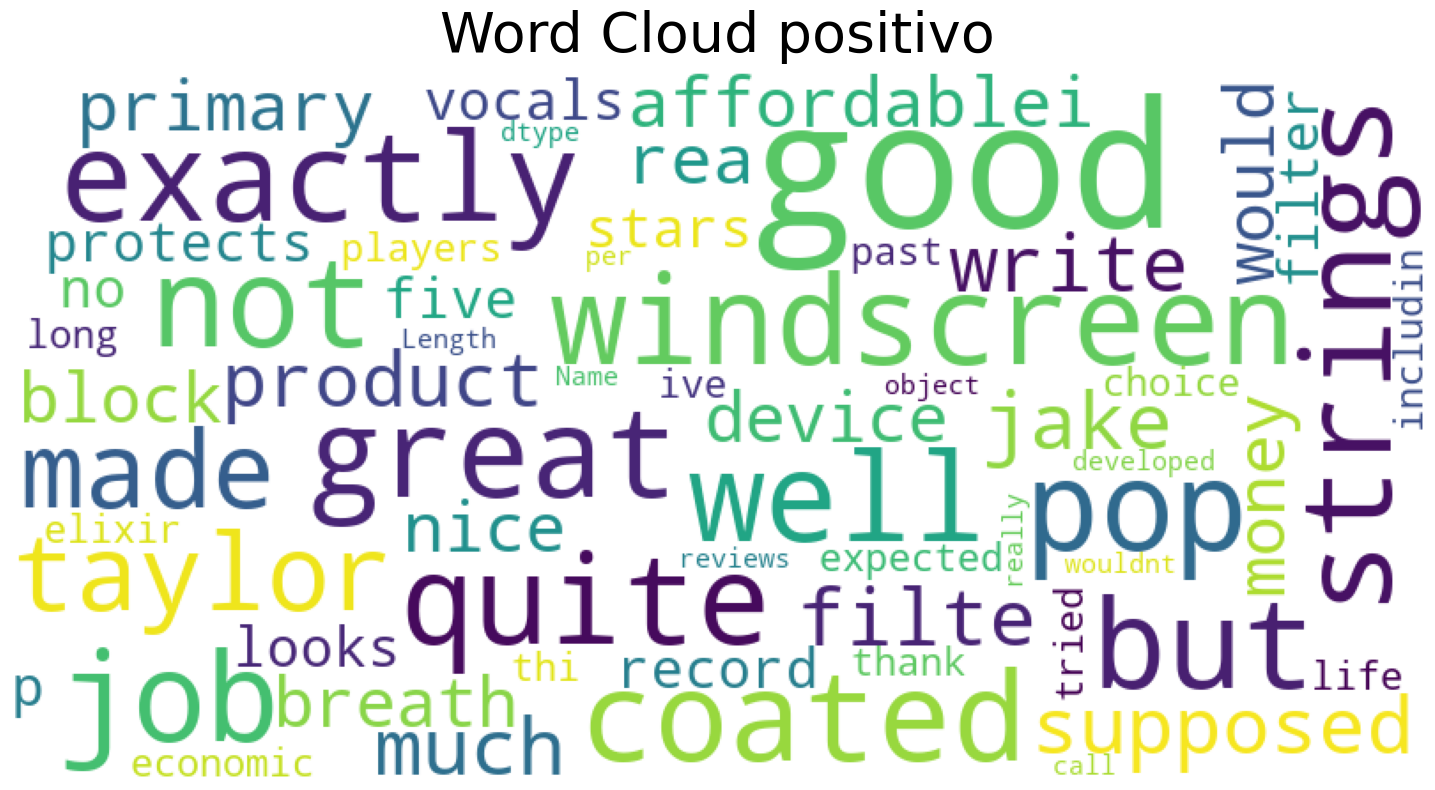

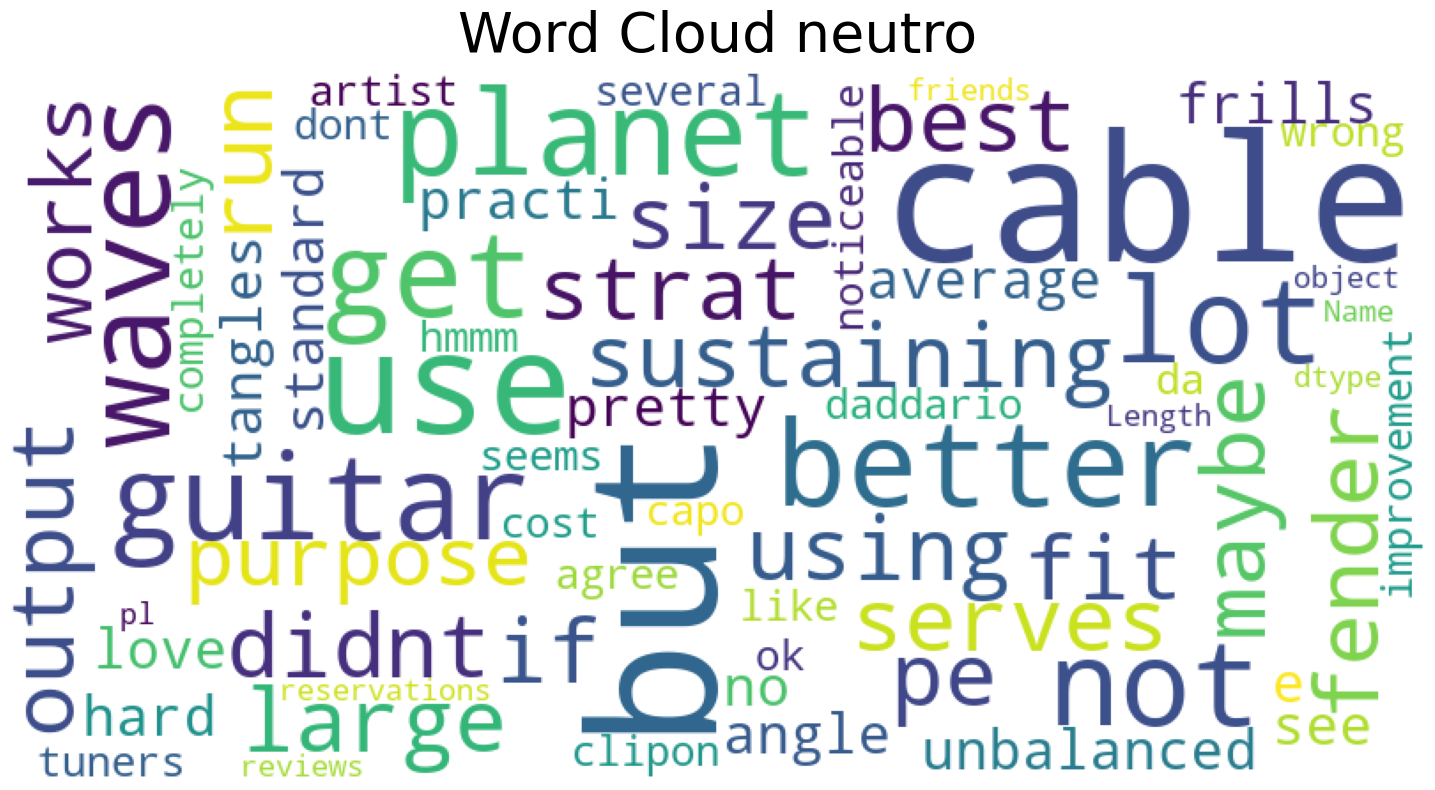

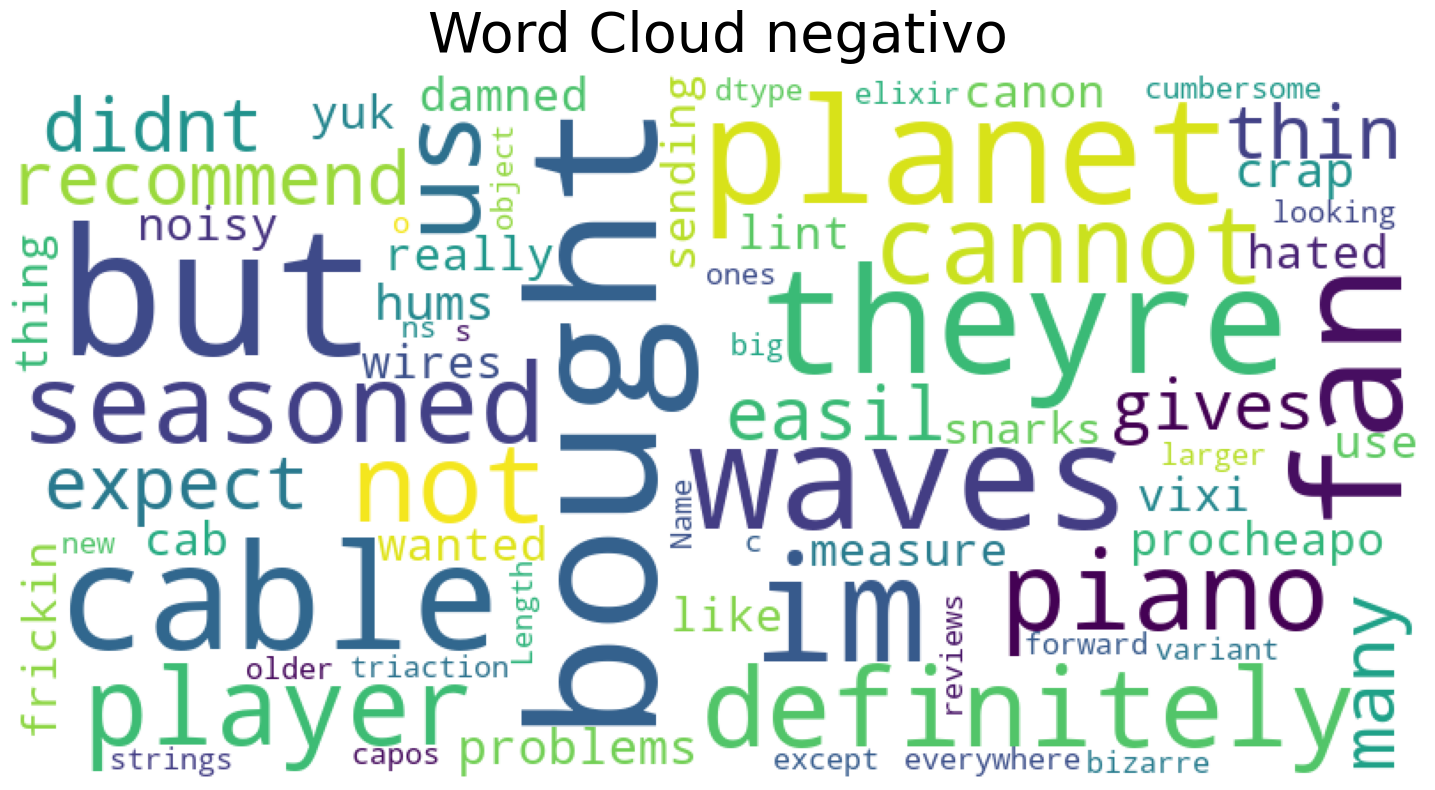

In [71]:
#Plot WordCloud das reviews positivas, neutras e negativas

stopwords = set(stop_words)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stopwords = stopwords.union(more_stopwords)

wordcloud = WordCloud(background_color='white',
                stopwords = stopwords,
                max_words = 200,
                max_font_size = 100, 
                random_state = 42,
                width=800, 
                height=400)

sentiments = ['positivo', 'neutro', 'negativo']
for idx, sentiment in enumerate(sentiments):
    plt.figure(figsize=(16,8))
    text = reviews[reviews['sentiment']==sentiment]['reviews']
    wordcloud.generate(str(text))
    plt.imshow(wordcloud);
    plt.title(f'Word Cloud {sentiment}', fontdict={'size': 40, 'color': 'black', 
                            'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

#### Extração de features

Codificando as classes de sentimentos numericamente para que possam ser utilizadas pelo algoritmo de classificação.

In [73]:

# instanciando a label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
reviews['sentiment']= label_encoder.fit_transform(reviews['sentiment']) 
  
print(reviews['sentiment'].unique())
print(reviews['sentiment'].value_counts())

[2 1 0]
sentiment
2    9015
1     772
0     467
Name: count, dtype: int64


Observando a contagem de valores únicos, fica claro que o dataset está desbalanceado, sendo necessário a utilização de técnicas de balanceamento.

Extração da raiz das palavras pelo método de stemming.

In [91]:
# Separando os textos de reviews para processamento
review_features=reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,good not much write but exactly supposed filte...
1,jake product exactly quite affordablei not rea...
2,job well primary job device block breath would...
3,good windscreen money nice windscreen protects...
4,no pops record vocals pop filter great looks p...


In [92]:
#Instanciando PorterStemmer
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(len(review_features)):
    try:
        review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    except:
        continue
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

Utilizando metodo de vetorização TF-IDF para extrair as features a partir do texto.

In [95]:

tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [96]:
X.shape

(10254, 5000)

In [97]:
y=reviews['sentiment']

Utilizando método de balanceamento SMOTE para balancear o dataset.

In [101]:

print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9015, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9015, 1: 9015, 0: 9015})


#### Split dos dados em treino e teste

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

#### Treinamento dos modelos

Treinamento dos modelos de classificação e avaliação dos resultados

In [103]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8818025008320258
Decision Tree Test Accuracy: 0.8188985879332478
KNN Test Accuracy: 0.8793644273284839
SVC Test Accuracy: 0.8797545761422526
Naive Bayes Test Accuracy: 0.8084573765035896


Como se observa, todos os modelos apresentaram bons resultados, sendo o modelo de regressão logística o melhor, neste cenário, com uma acurácia de 88%.